**Objective:** to gain practical skills in building and training neural networks using TensorFlow and Keras tools.

**Topics covered:** augmentation, search by hyperparameters, transfer learning with fine-tuning.


**Data:** Open Images Dataset V6 + Extensions ([source](https://storage.googleapis.com/openimages/web/index.html)).

## 1. Setup

The images that we have already downloaded from Open Images are stored on Google Drive, so we need to connect it. If the images are stored on a disk, we do not need to do this step.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To configure the hyperparameters of the model, we will use the Keras Tuner (information about which can be viewed at the [link](https://github.com/keras-team/keras-tuner)), but first, we need to install it, either in a working virtual environment, or, as in our case, through the current Colab notebook.

In [ ]:
!pip install -q keras-tuner

     |████████████████████████████████| 102kB 6.3MB/s 


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To build the neural network models, we will use the Keras API, which we can access by importing the corresponding module from TensorFlow.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras_tuner as kt 

In [ ]:
print(tf.__version__)

2.5.0


## 2. Image exploration for classification

For the classification task, we selected two classes "rabbit" and "squirrel" and downloaded the corresponding datasets from the Open Images, changing the storage format to the following:

```
image_store_dir/
    train/
        rabbit/
            image1.jpg
            image2.jpg
            ...
        squirrel/
            image3.jpg
            ...
    validation/
        ...
    test/
        ...
```

The "validation" and "test" directories are organized in the same way as the "train" directory. 

For our objective, we only need images that accurately contain rabbits or squirrels, as well as animals close to them or related to the same family, i.e. images with hares and with any representatives of squirrels (tree squirrels, chipmunks, prairie dogs, etc.). 

Since there aren't many images in our dataset, we manually checked whether they were correctly classified. As a result, they were deleted: 

1. images that do not have representatives of the selected classes, for example, instead of them there are guinea pigs, chinchillas and kangaroos;
2. ambiguous images, for example, with people in rabbit costumes;
3. those that contain both squirrels and rabbits. 

About ten of the images had mixed-up labels, which meant that the squirrels were labeled as rabbits and vice versa. We just moved them to the correct classes.

After all these transformations, we got a dataset with imbalanced classes, which has more training data of the "squirrel" class (almost 2 times), and validation and test data of the "rabbit" one. So we will use some of the validation and test images of rabbits for training so that these first two groups are equal for these two classes, but only those images that are not similar to the remaining ones.

As a result, we have 864 images of rabbits and 1749 images of squirrels for training, 41 images of each class for validation, and 84 images for testing.

Let's look at some of the training images we have.

In [ ]:
# Set parameters for loading
image_size = (180, 180)
image_shape = (*image_size, 3)
batch_size = 32
class_names = ['squirrel', 'rabbit']

In [ ]:
# Specify directories where all the project data is stored
project_dir = '/content/drive/MyDrive/Colab_Notebooks/Rabbit_Squirrel_Project'
image_store_dir = os.path.join(project_dir, 'Images_by_class')

train_dir = os.path.join(image_store_dir, 'train')
val_dir = os.path.join(image_store_dir, 'validation')
test_dir = os.path.join(image_store_dir, 'test')

In [ ]:
# Load images for viewing
train_img_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir, batch_size=batch_size, class_names=class_names)

Found 2613 files belonging to 2 classes.


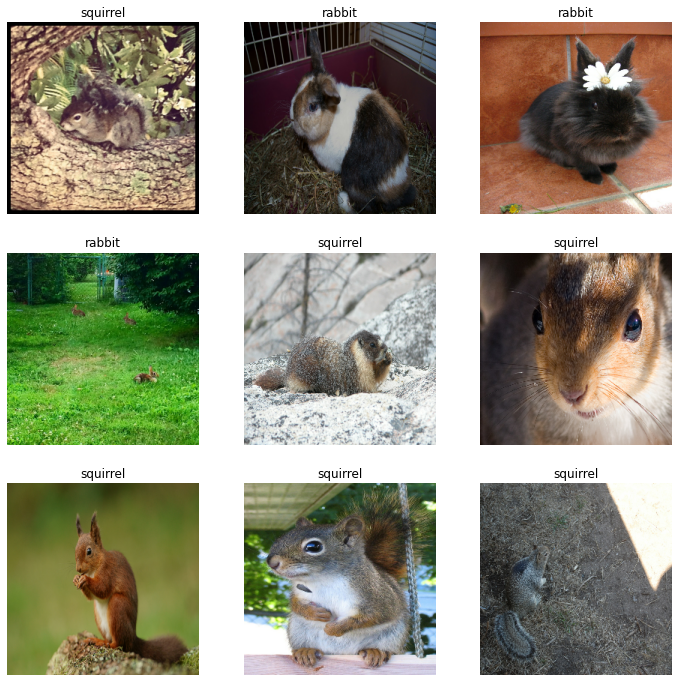

In [ ]:
# Show some images from the training dataset
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for images, labels in train_img_ds.take(1):
    for i in range(9):
        axs[i].imshow(images[i].numpy().astype('uint8'))
        axs[i].set_title(class_names[labels[i]])
        axs[i].axis('off')

## 3. Working with neural network models

### 3.1. Defining a model architecture and preparing for its training process

Our task is to classify images, so we will build a convolutional neural network (CNN), which will be simple, because our objective is not to create a high-accuracy model, although we will try to improve it later.

In [ ]:
# Set the model compilation parameters
monitor_metric = 'binary_accuracy'

compile_params = dict(
    loss=keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=[monitor_metric])

Since we are solving the binary classification problem and will use the BinaryCrossentropy loss with from_logits=True, we will have the last layer with one output without activation. Although it is possible to use this loss function with from_logits=False, then in the last layer we would add the sigmoid activation function. 

To make it easier to create models of the architecture we have defined, we will create a function.

In [ ]:
def build_sequential_cnn_model(compile_params_dict):
    """Returns a compiled model."""
    model = keras.Sequential([
        layers.Conv2D(8, 3, padding='same', activation='relu', 
                    input_shape=image_shape),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ])

    model.compile(**compile_params_dict)

    return model

The results of the obtained loss values and metrics can be visualized, both with the TensorBoard callbacks and with matplotlib tools. The first option also allows us to view the rendered graph of models and much more. To do this, we need to write the appropriate magic functions, with which the results will be displayed immediately in the notebook:

```
%load_ext tensorboard 
%tensorboard --logdir /path_to_logdir
```

Since we only want to look at the change in indicators, we will use the second option and create a function for this.

In [ ]:
def show_train_results(train_result, metric, colors=('cadetblue', 'salmon')):
    """Visualizes training and validation loss and metric from the "history" 
    attribute of a training result.
    
    Parameters:
    -----------
    train_result -- an object returned by the fit keras.Model method
    metric -- a name of metric from the compile keras.Model method
    colors -- training and validation line colors
    """
    val_metric = '_'.join(['val', metric])

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))
    
    for ax, param, val_param in ((ax1, 'loss', 'val_loss'), 
                                 (ax2, metric, val_metric)):

        history_param = train_result.history[param]
        history_val_param = train_result.history[val_param]
        optim_res_val_param = max(history_val_param)
        
        if val_param == 'val_loss':
            optim_res_val_param = min(history_val_param)

        optim_epoch = history_val_param.index(optim_res_val_param) + 1
        result_range = range(1, len(history_param) + 1)
        labels = [f"Train {param}", f"Val {val_param[4:]}"]

        ax.plot(result_range, history_param, color=colors[0], label=labels[0])
        ax.plot(result_range, history_val_param, color=colors[1], label=labels[1])
        ax.legend(loc='upper left')
        ax.grid(alpha=0.6)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("{}".format(param.title()))
        title = ("Training and validation {0}\n(the best val value: {1:0.4f}, epoch: {2})"
                     .format(param, optim_res_val_param, optim_epoch))
        ax.set_title(title)

    plt.show()

We will use callbacks to control the training process, for example, if the validation loss does not improve within 10 epochs, then we will stop it completely.

In [ ]:
# Set total parameters for training
epochs = 50
callbacks_es = [
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
    ]

Additionally, in the process of training some subsequent models, we plan to save two groups of weights: one will relate to the model with the best loss, and the second to the best value of binary accuracy.

In [ ]:
def add_modelcheckpoint_callbacks(other_callbacks, save_weights_dir, 
                                  metric_name=None, name_model='Model_1'):
    """Returns a list callbacks with ModelCheckpoint ones.
    
    Parameters:
    -----------
    other_callbacks -- a list of other callbacks to add to
    save_weights_dir -- a directory for storing selected model weights
    metric_name -- a name of metric for monitoring. If None, only val_loss 
    is monitored
    name_model (optional) -- a name of directory where weights relative 
    to this model will be stored    
    """
    callbacks = other_callbacks[:]
    monitors = ['val_loss']
    file_names = ['best_loss_weights']

    if metric_name:
        monitors.append(metric_name)
        metric_fname = '_'.join(['best', metric_name, 'weights'])
        file_names.append(metric_fname)    

    for file_name, monitor in zip(file_names, monitors):
        cp_filepath = os.path.join(save_weights_dir, name_model, file_name)

        mc = keras.callbacks.ModelCheckpoint(cp_filepath, 
                                             monitor=monitor, 
                                             save_best_only=True, 
                                             save_weights_only=True)
        callbacks.append(mc)

    return callbacks

In [ ]:
# Define a directory for storing all saved weights
save_weights_dir = os.path.join(project_dir, 'save_weights_keras')

# Set values for add_modelcheckpoint_callbacks function
callbacks_param = [callbacks_es, save_weights_dir, monitor_metric]

### 3.2. Data transformation and model training

Before using dataset in our neural network model, we need to transform them so that the training goes better, namely: bring them to a single size and scale the values to the range [0, 1]. 

Now the size of the images is different and is set in the range [0, 255] (since the RGB color mode is used). We also have, as mentioned earlier, imbalanced classes, and the total number of images is small. So we will see how our model will be trained on such data, then we will use class weights for balancing and finally apply augmentation (for a training dataset only) to increase the dataset. We will compare the obtained results, taking into account the **stochastic nature of neural networks**, which means that with each new call to the fit method, the values of the indicators will differ.

All of these transformations (except for setting weights) will be performed before loading the images using the ImageDataGenerator class. *(It would be possible to add the corresponding layers immediately to the model, but at the moment (June 2021) - they are experimental.)*

In [ ]:
# Set parameters for flow_from_directory ImageDataGenerator method
gen_flow_params = dict(
    target_size=image_size,
    classes=class_names,
    class_mode='binary',
    batch_size=batch_size,
    seed=0)

#### 3.2.1. Training only on scaled images

First, we will train the model on the data that we have, changing only their scale. At the same time, there is no need to shuffle a validation dataset, since models are not trained on them.

In [ ]:
# Create a generator for rescaling
rescale_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Create a DirectoryIterator for train and validation image datasets
train_rescale_di = rescale_datagen.flow_from_directory(train_dir, **gen_flow_params)
val_di = rescale_datagen.flow_from_directory(val_dir, shuffle=False, **gen_flow_params)

Found 2613 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [ ]:
# Build a base model
base_model = build_sequential_cnn_model(compile_params)

# View the architecture of the model
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        1

In [ ]:
callbacks_bm = add_modelcheckpoint_callbacks(*callbacks_param, name_model='base_model')

# Train the base model
history_bm = base_model.fit(train_rescale_di, epochs=epochs, 
                            callbacks=callbacks_bm, validation_data=val_di)

Epoch 1/50
82/82 [==============================] - 953s 11s/step - loss: 0.6473 - binary_accuracy: 0.6693 - val_loss: 0.7109 - val_binary_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 39s 472ms/step - loss: 0.6101 - binary_accuracy: 0.6693 - val_loss: 0.7013 - val_binary_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 38s 466ms/step - loss: 0.5832 - binary_accuracy: 0.6720 - val_loss: 0.6280 - val_binary_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 39s 472ms/step - loss: 0.5680 - binary_accuracy: 0.6824 - val_loss: 0.6190 - val_binary_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 38s 469ms/step - loss: 0.5553 - binary_accuracy: 0.6942 - val_loss: 0.6517 - val_binary_accuracy: 0.6585
Epoch 6/50
82/82 [==============================] - 39s 471ms/step - loss: 0.5464 - binary_accuracy: 0.7030 - val_loss: 0.5867 - val_binary_accuracy: 0.5244
Epoch 7/50
82/82 [==============================] - 38s 467

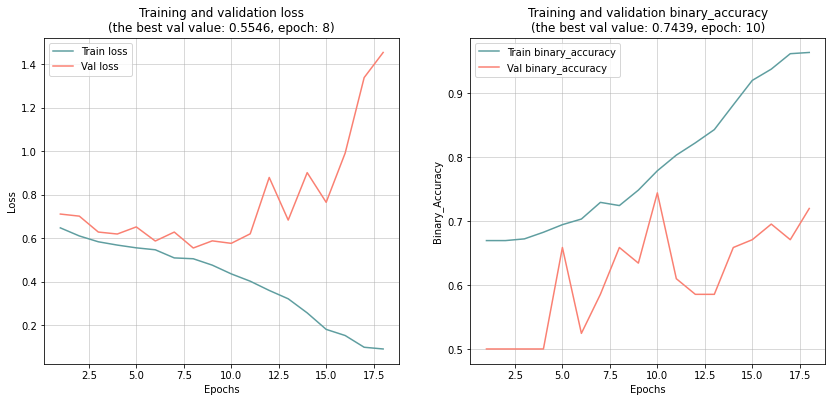

In [ ]:
# View the result
show_train_results(history_bm, monitor_metric)

As we can see from the plots and training process execution data above, the minimum validation loss and maximum validation binary accuracy were achieved by the model on the 8th and 10th training epochs, respectively. And then the indicators began to deteriorate (overfitting). The CNN completely stopped its training after the 18th epoch.

In [ ]:
# Delete the created TensorFlow graph to clear the memory
keras.backend.clear_session()

#### 3.2.2. Training with set class weights

Now we will train a model of the same architecture, but with the indication of class weights. Since we have twice as many images of the "squirrel" class, our weights will also differ by the same amount, but for the "rabbit" class. All other parameters will remain unchanged.

In [ ]:
class_weights = {0: 1.0, 1: 2.0}

In [ ]:
# Create a new model
model_clw = build_sequential_cnn_model(compile_params)

callbacks_clw = add_modelcheckpoint_callbacks(*callbacks_param, name_model='model_clw')

# Train the model
history_clw = model_clw.fit(train_rescale_di, class_weight=class_weights, 
                            epochs=epochs, callbacks=callbacks_clw, 
                            validation_data=val_di)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
82/82 [==============================] - 39s 474ms/step - loss: 0.9200 - binary_accuracy: 0.6693 - val_loss: 0.6651 - val_binary_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 38s 465ms/step - loss: 0.8741 - binary_accuracy: 0.6789 - val_loss: 0.6264 - val_binary_accuracy: 0.6829
Epoch 3/50
82/82 [==============================] - 38s 469ms/step - loss: 0.8453 - binary_accuracy: 0.6961 - val_loss: 0.5924 - val_binary_accuracy: 0.6220
Epoch 4/50
82/82 [==============================] - 38s 468ms/step - loss: 0.8172 - binary_accuracy: 0.6889 - val_loss: 0.5965 - val_binary_accuracy: 0.5976
Epoch 5/50
82/82 [==============================] - 38s 465ms/step - loss: 0.8002 - binary_accuracy: 0.7069 - val_loss: 0.5842 - val_binary_accuracy: 0.6829
Epoch 6/50
82/82 [==============================] - 39s 473ms/step - loss: 0.

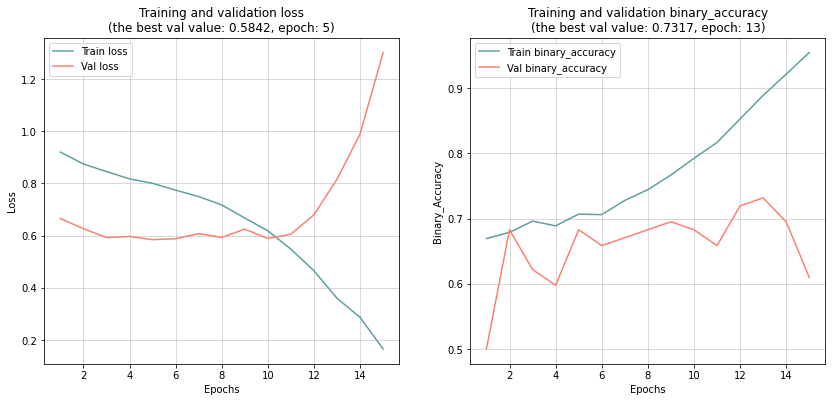

In [ ]:
# View the result
show_train_results(history_clw, monitor_metric)

In this case, the minimum values of the validation loss were reached a little faster (at the 5th epoch), and then overfitting began. The stopping of the training process was also started earlier (after the 15th epoch). Although this did not improve the performance and the values of the monitored indicators themselves do not differ much from the previous version. It should also be noted that the best value of the validation loss does not give the best value of binary accuracy, which, in turn, is achieved at high values of these losses. This may indicate that the model is not sure of its predictions.

In [ ]:
keras.backend.clear_session()

#### 3.2.3. Training with data augmentation

As noted earlier, the available number of images we have is small, so we will perform augmentation so that our model sees "new" images every time. The rest of the training parameters will remain the same, except for the class weights (adding them in the previous step did not improve the indicators).

In [ ]:
# Set parameters for augmentation
augment_params = dict(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=45,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# Create a generator for augmentation
augment_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    **augment_params)

In [ ]:
# Augment the training dataset
train_augment_di = augment_datagen.flow_from_directory(train_dir, **gen_flow_params)

Found 2613 images belonging to 2 classes.


In [ ]:
model_aug = build_sequential_cnn_model(compile_params)

callbacks_aug = add_modelcheckpoint_callbacks(*callbacks_param, name_model='model_aug')

history_aug = model_aug.fit(train_augment_di, epochs=epochs, 
                            callbacks=callbacks_aug, validation_data=val_di)

Epoch 1/50
82/82 [==============================] - 53s 641ms/step - loss: 0.6464 - binary_accuracy: 0.6693 - val_loss: 0.7571 - val_binary_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 52s 636ms/step - loss: 0.6337 - binary_accuracy: 0.6693 - val_loss: 0.7393 - val_binary_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 51s 628ms/step - loss: 0.6294 - binary_accuracy: 0.6693 - val_loss: 0.7127 - val_binary_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 51s 627ms/step - loss: 0.6171 - binary_accuracy: 0.6693 - val_loss: 0.6773 - val_binary_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 51s 627ms/step - loss: 0.6124 - binary_accuracy: 0.6693 - val_loss: 0.6986 - val_binary_accuracy: 0.5000
Epoch 6/50
82/82 [==============================] - 52s 629ms/step - loss: 0.6126 - binary_accuracy: 0.6678 - val_loss: 0.6792 - val_binary_accuracy: 0.5000
Epoch 7/50
82/82 [==============================] - 52s 62

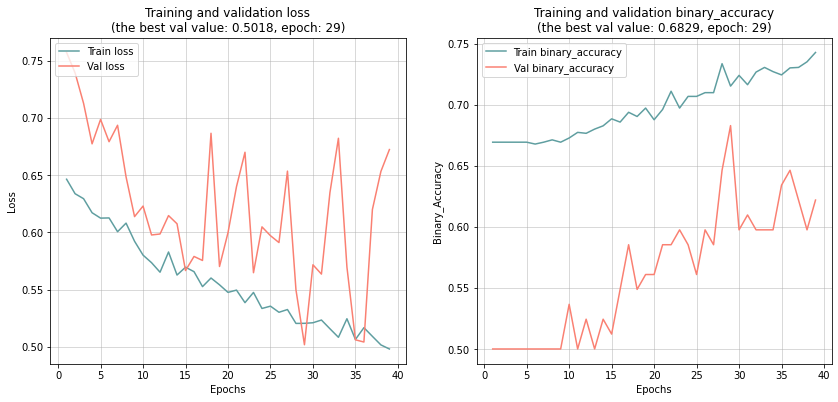

In [ ]:
# View the result
show_train_results(history_aug, monitor_metric)

With augmentation, our model was trained the longest and an early stop occurred only after the 39th epoch. And at the 29th epoch, the best-monitored parameters were obtained, with the lowest validation loss of all previously trained models.

In [ ]:
keras.backend.clear_session()

As a result, at the moment we are more satisfied with the training results, either with the number of images that we have initially or with augmentation. In the first case, we got the best validation binary accuracy, and in the second case, we got the best validation loss. **Of course, with each new start of training, there is no guarantee that these same models will remain the best.**


### 3.4. Improvement of the neural network model

We will try to improve the performance of the model with our base architecture, and we will do this in two different ways: by adding normalization and regularization layers and finding the best hyperparameter values. For training, we use the option without using class weights and with augmentation, because there the validation loss was lower.

#### 3.4.1. Improvement with normalization and regularization layers

We will see how the addition of normalization and regularization layers will affect the training of our CNN. To do this, we will use BatchNormalization and Dropout layers.

In [ ]:
def build_norm_reg_cnn_model(compile_params_dict):
    """Returns a compiled model with the BatchNormalization and Dropout layers."""
    norm_model = keras.Sequential([
        layers.Conv2D(8, 3, padding='same', input_shape=image_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(16, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(32, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(64, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(128, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(256, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ])

    norm_model.compile(**compile_params_dict)

    return norm_model

In [ ]:
# Create a new model with normalization and regularization layers
norm_model = build_norm_reg_cnn_model(compile_params)

callbacks_norm  = add_modelcheckpoint_callbacks(*callbacks_param, name_model='model_norm')

# Train the model
history_norm = norm_model.fit(train_augment_di, epochs=epochs, 
                              callbacks=callbacks_norm, validation_data=val_di)

Epoch 1/50
82/82 [==============================] - 1597s 19s/step - loss: 0.6416 - binary_accuracy: 0.6690 - val_loss: 0.6954 - val_binary_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 53s 647ms/step - loss: 0.6035 - binary_accuracy: 0.6693 - val_loss: 0.6916 - val_binary_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 53s 646ms/step - loss: 0.6008 - binary_accuracy: 0.6690 - val_loss: 0.7107 - val_binary_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 53s 644ms/step - loss: 0.5827 - binary_accuracy: 0.6705 - val_loss: 0.7004 - val_binary_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 52s 635ms/step - loss: 0.5840 - binary_accuracy: 0.6824 - val_loss: 0.8450 - val_binary_accuracy: 0.5366
Epoch 6/50
82/82 [==============================] - 52s 638ms/step - loss: 0.5787 - binary_accuracy: 0.6789 - val_loss: 0.6262 - val_binary_accuracy: 0.5732
Epoch 7/50
82/82 [==============================] - 52s 64

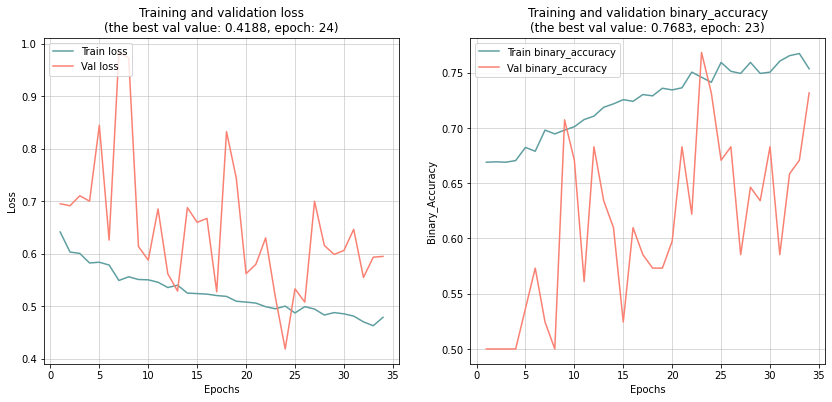

In [ ]:
# View the result
show_train_results(history_norm, monitor_metric)

As we can see, adding normalization and regularization layers in the above order improved the efficiency of training, reducing the validation loss to 0.4188 and increasing its binary accuracy to 0.7683. And it takes much less time to train the model than without them.



In [ ]:
keras.backend.clear_session()

#### 3.4.2. Search by hyperparameters with Keras Tuner

To select hyperparameters using the Keras Tuner, we first need to define a model-building function or a hyperclass with a special hp argument (an instance of the HyperParameters class), which determines which parameters and among which values to look for. To do this, we will search only among some hyperparameters to see if there are better values for them than we currently have. As a basis, we will take the architecture of the model with normalization and regularization layers.

In [ ]:
def build_model(hp):
    """Returns a compiled model with configurable hyperparameters."""
    model = keras.Sequential([
        layers.Conv2D(8, kernel_size=hp.Int('kernel_size1', min_value=3, max_value=5, step=2), 
                      padding='same', input_shape=image_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=hp.Int('strides1', min_value=1, max_value=3)),
        layers.Conv2D(16, kernel_size=hp.Int('kernel_size2', min_value=3, max_value=5, step=2), 
                      padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=hp.Int('strides2', min_value=1, max_value=3)),
        layers.Conv2D(32, kernel_size=hp.Int('kernel_size3', min_value=3, max_value=5, step=2), 
                      padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=hp.Int('strides3', min_value=1, max_value=3)),
        layers.Conv2D(64, kernel_size=hp.Int('kernel_size4', min_value=3, max_value=5, step=2), 
                      padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(128, kernel_size=hp.Int('kernel_size5', min_value=3, max_value=5, step=2), 
                      padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(256, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(strides=hp.Int('strides4', min_value=1, max_value=2)),
        layers.Flatten(),
        layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                     activation=hp.Choice('activation_dense', ['relu', 'selu', 'elu'])),
        layers.Dense(1),
    ])
        
    model.compile(**compile_params)
    
    return model

Now we will create instances of the tuner that will use the function we have defined, and run the search. At the same time, we will have two tuners: the first one will use the metric we monitor for a set for validation as an objective, and the second one will use its loss. Theoretically, with lower losses, the binary accuracy should be higher, but as we noted earlier, in practice this is not always the case. 

We chose the RandomSearch tuner with 5 trials, although there are others (BayesianOptimization and Hyperband, for example). We can also set the executions_per_trial parameter to reduce results variance, but this will increase the search time by the same number of times.

In [ ]:
tuner_objective = '_'.join(['val', monitor_metric])

# Create a tuner with the objective to improve val_binary_accuracy
tuner = kt.RandomSearch(build_model,
                        objective=tuner_objective,
                        max_trials=5,
                        directory=project_dir,
                        project_name='Keras_Tuner_results_v3')

We will search for only 25 epochs, because the model that we trained above showed the best results from all the previous ones about this number of epochs.

In [ ]:
# Start searching for hyperparameters
tuner.search(train_augment_di, epochs=25, 
             validation_data=val_di)

Trial 5 Complete [00h 22m 21s]
val_binary_accuracy: 0.6585366129875183

Best val_binary_accuracy So Far: 0.8170731663703918
Total elapsed time: 01h 50m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# View the top two hyperparameter values
tuner.results_summary(2)

Results summary
Results in /content/drive/MyDrive/Colab_Notebooks/Rabbit_Squirrel_Project/Keras_Tuner_results_v3
Showing 2 best trials
Objective(name='val_binary_accuracy', direction='max')
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 1
kernel_size2: 3
strides2: 2
kernel_size3: 3
strides3: 3
kernel_size4: 3
kernel_size5: 5
strides4: 1
dropout_rate: 0.4
units: 64
activation_dense: selu
Score: 0.8170731663703918
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 2
kernel_size2: 5
strides2: 3
kernel_size3: 5
strides3: 2
kernel_size4: 3
kernel_size5: 5
strides4: 1
dropout_rate: 0.2
units: 96
activation_dense: elu
Score: 0.7560975551605225


In [ ]:
# Create a tuner with the objective to improve val_loss
tuner_bl = kt.RandomSearch(build_model,
                           objective='val_loss',
                           max_trials=5,
                           directory=project_dir,
                           project_name='Keras_Tuner_results_bl')

In [ ]:
tuner_bl.search(train_augment_di, epochs=25, 
                validation_data=val_di)

Trial 5 Complete [00h 21m 54s]
val_loss: 0.5516855120658875

Best val_loss So Far: 0.4888652563095093
Total elapsed time: 01h 54m 03s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_bl.results_summary(2)

Results summary
Results in /content/drive/MyDrive/Colab_Notebooks/Rabbit_Squirrel_Project/Keras_Tuner_results_bl
Showing 2 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 2
kernel_size2: 3
strides2: 3
kernel_size3: 5
strides3: 1
kernel_size4: 3
kernel_size5: 5
strides4: 1
dropout_rate: 0.1
units: 64
activation_dense: selu
Score: 0.4888652563095093
Trial summary
Hyperparameters:
kernel_size1: 5
strides1: 2
kernel_size2: 5
strides2: 2
kernel_size3: 3
strides3: 1
kernel_size4: 5
kernel_size5: 5
strides4: 2
dropout_rate: 0.2
units: 64
activation_dense: relu
Score: 0.5233447551727295


The best validation binary accuracy obtained as a result of the search is higher than in our best model. When searching for hyperparameters by validation loss, we could not find the best combination of them. Although in general, it is not entirely clear what the loss is in the first case and the binary accuracy in the second. Therefore, we will receive the corresponding models from the tuner for their evaluation on the test dataset. But if we need to use them in the future, then to improve performance, we can get not the model itself, but its best hyperparameters to create a model with them and train it.

In [ ]:
# Get the model with the best val_binary_accuracy value
best_ba_tuner_model = tuner.get_best_models()[0]

In [ ]:
# Get the model with the best val_loss value
best_loss_tuner_model = tuner_bl.get_best_models()[0]

### 3.5. Evaluating the better models on the test dataset

At the end of this section, we will evaluate the four better models: the two that we found by searching for hyperparameters, and two with loaded weights with the best indicators on the test image dataset.

To do this, we will create a DirectoryIterator for the dataset used and two instances of the model with the normalization and regularization layers to load the weights with the best val_loss and val_binary_accuracy values into them.

In [ ]:
# Create a DirectoryIterator for the test image dataset
test_di = rescale_datagen.flow_from_directory(test_dir, shuffle=False, **gen_flow_params)

Found 168 images belonging to 2 classes.


In [ ]:
# Define the path where the best weights are stored
load_loss_weights_dir = os.path.join(save_weights_dir, 'model_norm/best_loss_weights')
load_ba_weights_dir = os.path.join(save_weights_dir, 'model_norm/best_binary_accuracy_weights')

In [ ]:
best_loss_norm_model = build_norm_reg_cnn_model(compile_params)
best_ba_norm_model = build_norm_reg_cnn_model(compile_params)

# Load model weights with the best val_loss and val_binary_accuracy
best_loss_norm_model.load_weights(load_loss_weights_dir)
best_ba_norm_model.load_weights(load_ba_weights_dir)

In [ ]:
# Evaluate the loaded model with the best val_loss weights
_ = best_loss_norm_model.evaluate(test_di)

6/6 [==============================] - 68s 8s/step - loss: 0.6114 - binary_accuracy: 0.7083


In [ ]:
# Evaluate the loaded model with the best weights val_binary_accuracy weights
_ = best_ba_norm_model.evaluate(test_di)

6/6 [==============================] - 3s 375ms/step - loss: 0.6859 - binary_accuracy: 0.6310


In [ ]:
# Evaluate the tuner model with the best val_loss
_ = best_loss_tuner_model.evaluate(test_di)

6/6 [==============================] - 3s 383ms/step - loss: 0.6032 - binary_accuracy: 0.6548


In [ ]:
# Evaluate the tuner model with the best val_binary_accuracy
_ = best_ba_tuner_model.evaluate(test_di)

6/6 [==============================] - 3s 400ms/step - loss: 0.6219 - binary_accuracy: 0.6488


As we can see, if we compare the variants of models based on validation losses or binary accuracy, then the third or first variant, respectively, is obtained in the first place. But they are all the results of choosing weights with the best validation losses. The weights with the better values of validation binary accuracy show worse results.

## 4. Training a model using transfer learning


Before going directly to the implementation of transfer learning, we will load the data that we will use when training a model. We will not use the previously loaded ones, since their range was changed by the generator, and each model already trained needs its own preparation.

In [ ]:
# Set parameters for image loading
load_params = dict(class_names=class_names, labels='inferred', 
                   batch_size=batch_size, image_size=image_size)

In [ ]:
# Load images 
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir, **load_params)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir, shuffle=False, **load_params)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir, shuffle=False, **load_params)

Found 2613 files belonging to 2 classes.
Found 82 files belonging to 2 classes.
Found 168 files belonging to 2 classes.


There are various ways to use pre-trained models for transfer learning. We, in turn, implement one of them, namely: we use a pre-trained model to extract features, and build a classifier on top of it, which we will train. And then we will fine-tune it.

The pre-trained model we can find in Keras Applications. Let's take, for example, ResNet50V2 and import it. Information about this network can be found at: [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027) (CVPR 2016).

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2

Now we will create an instance of this model with pre-trained weights on the ImageNet and without the top (output) pooling and fully connected layers.

In [ ]:
pretrain_model = ResNet50V2(include_top=False,
                            weights='imagenet',
                            input_shape=image_shape)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
# Look at the architecture of the loaded model
pretrain_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 92, 92, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Note that the ResNet50V2 model contains BatchNormalization layers, this will be important when implementing fine-tuning.

To use weights of the pre-trained model and not change them during training of a new model, all layers must be frozen.

In [ ]:
# Freeze the pre-trained model
pretrain_model.trainable = False

This model expects inputs in the range [-1, 1] and a size of at least 32 x 32. The available images are sized as required, but the data range is different. To scale to the specified range, we will use the preprocess_input function from the resnet_v2 module.

As the top layer, we will use several of the top layers of our base model created earlier. And here it is important to specify the training=False parameter in the built-in model, so that when fine-tuning, we do not destroy everything that the model has learned.

In [ ]:
# Create a classifier
inputs = keras.Input(shape=image_shape)
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = pretrain_model(x, training=False)
x = layers.MaxPooling2D(strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)
new_model = keras.Model(inputs, outputs)

new_model.compile(**compile_params)

*When compiling the model, due to Lambda layers available in the pre-trained model, warnings similar to the following were issued at the output:*

```
WARNING:tensorflow:
The following Variables were used a Lambda layer's call (tf.nn.convolution_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
```

To continue using the resulting new model, we need to train new layers.

In [ ]:
# Set parameters for model training
fit_params = dict(epochs=20, 
                  callbacks=keras.callbacks.EarlyStopping(patience=5), 
                  validation_data=val_ds)

In [ ]:
# Train the new model layers
history_new_layers = new_model.fit(train_ds, **fit_params)

Epoch 1/20
82/82 [==============================] - 817s 9s/step - loss: 0.5159 - binary_accuracy: 0.8890 - val_loss: 0.2771 - val_binary_accuracy: 0.8780
Epoch 2/20
82/82 [==============================] - 22s 252ms/step - loss: 0.1140 - binary_accuracy: 0.9483 - val_loss: 0.1684 - val_binary_accuracy: 0.9268
Epoch 3/20
82/82 [==============================] - 22s 254ms/step - loss: 0.0642 - binary_accuracy: 0.9698 - val_loss: 0.1656 - val_binary_accuracy: 0.9390
Epoch 4/20
82/82 [==============================] - 22s 252ms/step - loss: 0.0347 - binary_accuracy: 0.9782 - val_loss: 0.2817 - val_binary_accuracy: 0.9268
Epoch 5/20
82/82 [==============================] - 22s 253ms/step - loss: 0.0266 - binary_accuracy: 0.9874 - val_loss: 0.2424 - val_binary_accuracy: 0.9024
Epoch 6/20
82/82 [==============================] - 22s 252ms/step - loss: 0.0148 - binary_accuracy: 0.9931 - val_loss: 0.1349 - val_binary_accuracy: 0.9512
Epoch 7/20
82/82 [==============================] - 22s 253m

At the moment, the best loss and binary accuracy in the validation dataset are 8.3180e-04 and 0.9512, respectively. But now we can fine-tune it by starting the training process again, unfreezing all the layers before doing so, and setting the learning rate very low to prevent overfitting.

In [ ]:
# Unfreeze the pre-trained model
pretrain_model.trainable = True

new_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(1e-5), 
                  metrics=[monitor_metric])

In [ ]:
# Perform fine-tuning of the model
history_ft = new_model.fit(train_ds, **fit_params)

Epoch 1/20
82/82 [==============================] - 25s 259ms/step - loss: 7.9410e-04 - binary_accuracy: 1.0000 - val_loss: 0.1392 - val_binary_accuracy: 0.9390
Epoch 2/20
82/82 [==============================] - 22s 251ms/step - loss: 7.7174e-04 - binary_accuracy: 1.0000 - val_loss: 0.1391 - val_binary_accuracy: 0.9390
Epoch 3/20
82/82 [==============================] - 22s 251ms/step - loss: 7.5328e-04 - binary_accuracy: 1.0000 - val_loss: 0.1421 - val_binary_accuracy: 0.9390
Epoch 4/20
82/82 [==============================] - 22s 252ms/step - loss: 7.3403e-04 - binary_accuracy: 1.0000 - val_loss: 0.1414 - val_binary_accuracy: 0.9390
Epoch 5/20
82/82 [==============================] - 22s 249ms/step - loss: 7.1846e-04 - binary_accuracy: 1.0000 - val_loss: 0.1432 - val_binary_accuracy: 0.9390
Epoch 6/20
82/82 [==============================] - 22s 249ms/step - loss: 7.0548e-04 - binary_accuracy: 1.0000 - val_loss: 0.1433 - val_binary_accuracy: 0.9390
Epoch 7/20
82/82 [================

As we can see, in our case, the val_binary_accuracy remains the same as at the end of the previous training, but the val_loss has improved. If we compare in general the results of our previously trained models and transfer learning, it is obvious that the latter has better ones.

At the end, we will evaluate our new model on the test data.

In [ ]:
_ = new_model.evaluate(test_ds)

6/6 [==============================] - 46s 7s/step - loss: 0.0855 - binary_accuracy: 0.9881


And as expected, we also got improved performance on previously unseen images. Moreover, the validation loss values are less, and the validation binary accuracy is higher than that of all previously trained models in this notebook.